# **Assignment 2**

This assignment focuses on Airbnbs in Berlin, Germany. The goal is to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. This assignment will build a prediction model for prices, and discuss the modeling decisions and compare the results to those of the case study. 

Task
• You may use other variables we used in class.

• You may do different feature engineering depending on the selected environment.

• You may make other sample design decisions!

• In each case, document your steps!

• Have at least 3 different models and compare performance

• Argue for your choice of models
- One model must be theoretically profound linear regression via OLS.
- One model must be Random Forest or any boosting algorithm

### Import Libraries

In [104]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import os
from pathlib import Path
import sys
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## ***Data Prep***

### Import Data from GitHub

In [2]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://github.com/Iandrewburg/Assignment_1/raw/main/Assignment_2/berlin_airbnb.csv')

### Inspect Data

In [3]:
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176.0,https://www.airbnb.com/rooms/3176,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.63 · 1 bedroom · 2 ...,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,...,4.69,4.92,4.62,First name and Last name: Nicolas Krotz <br/> ...,f,1,1,0,0,0.85
1,9991.0,https://www.airbnb.com/rooms/9991,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★5.0 · 4 bedrooms · 7 ...,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,...,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.08
2,14325.0,https://www.airbnb.com/rooms/14325,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.67 · Studio · 1 bed...,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,...,4.84,4.58,4.42,NaN,f,4,4,0,0,0.16
3,16644.0,https://www.airbnb.com/rooms/16644,2.023090e+13,16/09/2023,city scrape,Condo in Berlin · ★4.72 · 1 bedroom · 1 bed · ...,Light and sunny 2-Room-turn of the century-fla...,Our Part of Kreuzberg is just the best. Good v...,https://a0.muscache.com/pictures/73759174/e2ef...,64696,...,4.86,4.67,4.71,NaN,f,2,2,0,0,0.30
4,17904.0,https://www.airbnb.com/rooms/17904,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.77 · Studio · 1 bed...,"- apt is available starting April 1, 2023<br /...",NaN,https://a0.muscache.com/pictures/d9a6f8be-54b9...,68997,...,4.92,4.87,4.65,NaN,f,1,1,0,0,1.81


In [4]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13134 entries, 0 to 13133
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            13134 non-null  float64
 1   listing_url                                   13134 non-null  object 
 2   scrape_id                                     13134 non-null  float64
 3   last_scraped                                  13134 non-null  object 
 4   source                                        13134 non-null  object 
 5   name                                          13134 non-null  object 
 6   description                                   12997 non-null  object 
 7   neighborhood_overview                         6771 non-null   object 
 8   picture_url                                   13134 non-null  object 
 9   host_id                                       13134 non-null 

In [6]:
data.room_type.value_counts()

room_type
Entire home/apt    8431
Private room       4309
Shared room         262
Hotel room          132
Name: count, dtype: int64

In [7]:
data.property_type.value_counts()

property_type
Entire rental unit             6545
Private room in rental unit    3261
Entire condo                    756
Entire serviced apartment       407
Room in hotel                   297
                               ... 
Shared room in condo              1
Private room in boat              1
Treehouse                         1
Island                            1
Dome                              1
Name: count, Length: 67, dtype: int64

In [8]:
# check for missing values in the columns being focused on for this project
columns_missing_value = [
    'accommodates', 'beds', 'review_scores_rating', 'host_is_superhost',
    'number_of_reviews', 'availability_365', 'minimum_nights',
    'maximum_nights', 'property_type', 'room_type', 'price', 'amenities'
]

missing_values = data[columns_missing_value].isnull().sum()

missing_values

accommodates               0
beds                     162
review_scores_rating    2756
host_is_superhost         83
number_of_reviews          0
availability_365           0
minimum_nights             0
maximum_nights             0
property_type              0
room_type                  0
price                      0
amenities                  0
dtype: int64

### Data Cleaning Function

In [9]:
def airbnb_cleaner(data): 
    """
    Function that cleans the airbnb dataset for berlin to the desired dataframe.
    """
    
    
    """
    Step 1: Handling the amenities column. There are a lot of amenities, so this 
    will also filter for just the top 15 amenities by frequency.
    """
    # Convert the string representations of lists into actual lists
    data['amenities'] = data['amenities'].apply(lambda x: ast.literal_eval(x))

    # Flatten the list to count each amenity's occurrence
    all_amenities = [amenity for sublist in data['amenities'] for amenity in sublist]

    # Find the top 15 most frequent amenities
    amenities_series = pd.Series(all_amenities)
    top_15_amenities = amenities_series.value_counts().head(15).index.tolist()

    # Create binary variables for these top 15 amenities
    for amenity in top_15_amenities:
        # Correctly format column names by replacing spaces with underscores
        # Ensure any potential quotes are handled correctly
        column_name = "amenities_" + amenity.replace(' ', '_').replace('"', '')
        data[column_name] = data['amenities'].apply(lambda x: 1 if amenity in x else 0)
    
    
    
    """
    Step 2: Remove unnecessary columns for this project.
    """
    # Define the top amenities columns to keep
    top_amenities_columns = [
        'amenities_Kitchen', 'amenities_Wifi', 'amenities_Essentials', 'amenities_Hair_dryer', 'amenities_Heating',
        'amenities_Hangers', 'amenities_Smoke_alarm', 'amenities_Hot_water', 'amenities_Dishes_and_silverware',
        'amenities_Washer', 'amenities_Iron', 'amenities_Refrigerator', 'amenities_Cooking_basics',
        'amenities_Bed_linens', 'amenities_Shampoo'
    ]
    
    # columns to keep
    columns = list(set([
        'accommodates', 'beds', 'review_scores_rating', 'host_is_superhost',
        'number_of_reviews',
        'availability_365', 'minimum_nights', 'maximum_nights', 'property_type',
        'room_type', 'price'
    ] + top_amenities_columns))

    # Creating a new DataFrame with only the selected columns
    data = data[columns]
    
    
    
    """
    Step 3: Clean the price column.
    """
    # Remove 0 values
    data = data[data['price'] != 0]
    
    # Drop null values
    data = data.dropna(subset=['price'])
    
    # Remove $ sign and change type to numeric
    data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float).astype(int)
    
    
    
    """
    Step 4: Filter the dataset. The following filtering is conducted: 
    - Listings that accomodate 2-6 people
    - The IQR of prices
    - Excluding hotel listings
    """
    # Calculate price IQR
    Q1, Q3 = data['price'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    # Filters
    data = data[
        (data['accommodates'] >= 2) & 
        (data['accommodates'] <= 6) & 
        (data['price'] >= lower_bound) & 
        (data['price'] <= upper_bound) & 
        ~((data['property_type'] == 'Room in hotel') & (data['room_type'] == 'Hotel room'))
    ] 
    
   

    """
    Step 5: Handle the 'property_type' and 'room_type' columns.
    
    There are a lot of property types, so any property types with
    under 100 values were removed so that only the top property 
    types were analyzed. 
    
    The remaining property types and room types categories were then 
    transformed to binary variables. 
    """
    # Remove property types that appear in less than 100 listings
    property_type_value_counts = data['property_type'].value_counts()
    to_remove = property_type_value_counts[property_type_value_counts < 100].index
    data = data[~data['property_type'].isin(to_remove)]
    
    # Create dummy variables for 'property_type' and concatenate them with the main DataFrame
    property_dummies = pd.get_dummies(data['property_type'], prefix='d_type')
    data = pd.concat([data, property_dummies], axis=1)

    # Create dummy variables for 'room_type' and concatenate them with the main DataFrame
    room_dummies = pd.get_dummies(data['room_type'], prefix='d_room')
    data = pd.concat([data, room_dummies], axis=1)

    # Ensure dummy columns created for 'property_type' and 'room_type' are of integer type
    d_columns = data.columns[data.columns.str.startswith('d_')]
    data[d_columns] = data[d_columns].astype(int)
    
    
    
    """
    Step 6: Renaming columns
    
    All spaces in column names were replaced with an underscore. 
    Furthermore, the column names were made to be lowercase
    
    Columns were then manulally renamed for more efficient naming
    """
    # Rename all columns to lowercase and replace spaces with underscores
    data.rename(columns=lambda x: x.replace(" ", "_").lower(), inplace=True)
    
    # Further rename specific columns with prefixes
    data = data.rename(columns={
        'review_scores_rating': 'n_review_scores_rating',
        'minimum_nights': 'n_minimum_nights',
        'accommodates': 'n_accommodates',
        'beds': 'n_beds',
        'availability_365': 'n_availability_365',
        'number_of_reviews': 'n_number_of_reviews',
        'maximum_nights': 'n_maximum_nights',
        'room_type': 'f_room_type',
        'property_type': 'f_property_type',
        'd_room_entire_home/apt': 'd_room_entire_apt',
        'host_is_superhost': 'd_host_is_superhost'
    })

    
    """
    Step 7: Take care of missing values and data types
    """
    data['n_accommodates'] = data['n_accommodates'].fillna(0).astype(int)
    data['n_beds'] = data['n_beds'].fillna(0).astype(int)
    data['n_review_scores_rating'] = data['n_review_scores_rating'].fillna(0)
    data['n_number_of_reviews'] = data['n_number_of_reviews'].fillna(0).astype(int)
    data['n_availability_365'] = data['n_availability_365'].fillna(0).astype(int)
    data['n_minimum_nights'] = data['n_minimum_nights'].fillna(0).astype(int)
    data['n_maximum_nights'] = data['n_maximum_nights'].fillna(0).astype(int)
    data['f_property_type'] = data['f_property_type'].fillna("Missing")
    data['f_room_type'] = data['f_room_type'].fillna("Missing")
    data['d_host_is_superhost'] = data['d_host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0).astype(int)
    # resort the data by alphabetical order
    data = data.reindex(sorted(data.columns), axis=1)
    
    return data

data = airbnb_cleaner(data)

data

,amenities_bed_linens,amenities_cooking_basics,amenities_dishes_and_silverware,amenities_essentials,amenities_hair_dryer,amenities_hangers,amenities_heating,amenities_hot_water,amenities_iron,amenities_kitchen,...,f_property_type,f_room_type,n_accommodates,n_availability_365,n_beds,n_maximum_nights,n_minimum_nights,n_number_of_reviews,n_review_scores_rating,price
0,0,1,0,1,1,1,1,0,1,1,...,Entire rental unit,Entire home/apt,4,123,2,184,63,148,4.63,83
3,0,0,0,1,1,1,1,0,1,1,...,Entire condo,Entire home/apt,4,131,1,365,93,48,4.72,90
4,0,1,1,1,1,1,1,1,1,1,...,Entire rental unit,Entire home/apt,2,10,1,365,92,299,4.77,25
5,0,1,1,1,1,1,1,1,1,1,...,Entire loft,Entire home/apt,4,134,2,30,3,116,4.49,179
6,1,1,1,1,1,1,1,1,1,1,...,Entire rental unit,Entire home/apt,2,77,2,730,93,60,4.74,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13129,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,238,1,365,1,0,0.00,100
13130,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,16,1,365,5,0,0.00,90
13131,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,25,1,365,5,0,0.00,95
13132,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,5,262,2,365,3,0,0.00,130


### Inspect Data Post-Cleaning

In [10]:
# double check missing values
missing_values_count = data.isnull().sum()

missing_values_table = pd.DataFrame(missing_values_count, columns=['Missing Values'])

missing_values_table

,Missing Values
amenities_bed_linens,0
amenities_cooking_basics,0
amenities_dishes_and_silverware,0
amenities_essentials,0
amenities_hair_dryer,0
amenities_hangers,0
amenities_heating,0
amenities_hot_water,0
amenities_iron,0
amenities_kitchen,0


In [11]:
data.dtypes

amenities_bed_linens                    int64
amenities_cooking_basics                int64
amenities_dishes_and_silverware         int64
amenities_essentials                    int64
amenities_hair_dryer                    int64
amenities_hangers                       int64
amenities_heating                       int64
amenities_hot_water                     int64
amenities_iron                          int64
amenities_kitchen                       int64
amenities_refrigerator                  int64
amenities_shampoo                       int64
amenities_smoke_alarm                   int64
amenities_washer                        int64
amenities_wifi                          int64
d_host_is_superhost                     int32
d_room_entire_apt                       int32
d_room_private_room                     int32
d_type_entire_condo                     int32
d_type_entire_home                      int32
d_type_entire_loft                      int32
d_type_entire_rental_unit         

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9832 entries, 0 to 13133
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   amenities_bed_linens                9832 non-null   int64  
 1   amenities_cooking_basics            9832 non-null   int64  
 2   amenities_dishes_and_silverware     9832 non-null   int64  
 3   amenities_essentials                9832 non-null   int64  
 4   amenities_hair_dryer                9832 non-null   int64  
 5   amenities_hangers                   9832 non-null   int64  
 6   amenities_heating                   9832 non-null   int64  
 7   amenities_hot_water                 9832 non-null   int64  
 8   amenities_iron                      9832 non-null   int64  
 9   amenities_kitchen                   9832 non-null   int64  
 10  amenities_refrigerator              9832 non-null   int64  
 11  amenities_shampoo                   9832 non-nu

In [13]:
data.isna().sum().sum()

0

In [14]:
data.shape

(9832, 37)

In [15]:
data.columns

Index(['amenities_bed_linens', 'amenities_cooking_basics',
       'amenities_dishes_and_silverware', 'amenities_essentials',
       'amenities_hair_dryer', 'amenities_hangers', 'amenities_heating',
       'amenities_hot_water', 'amenities_iron', 'amenities_kitchen',
       'amenities_refrigerator', 'amenities_shampoo', 'amenities_smoke_alarm',
       'amenities_washer', 'amenities_wifi', 'd_host_is_superhost',
       'd_room_entire_apt', 'd_room_private_room', 'd_type_entire_condo',
       'd_type_entire_home', 'd_type_entire_loft', 'd_type_entire_rental_unit',
       'd_type_entire_serviced_apartment', 'd_type_private_room_in_condo',
       'd_type_private_room_in_home', 'd_type_private_room_in_rental_unit',
       'd_type_room_in_hotel', 'f_property_type', 'f_room_type',
       'n_accommodates', 'n_availability_365', 'n_beds', 'n_maximum_nights',
       'n_minimum_nights', 'n_number_of_reviews', 'n_review_scores_rating',
       'price'],
      dtype='object')

### EDA

***numerical variables***

In [16]:
# too long to display and read
data.describe().T

,count,mean,std,min,25%,50%,75%,max
amenities_bed_linens,9832.0,0.532547,0.498965,0.0,0.00,1.00,1.00,1.0
amenities_cooking_basics,9832.0,0.584215,0.492882,0.0,0.00,1.00,1.00,1.0
amenities_dishes_and_silverware,9832.0,0.619711,0.485482,0.0,0.00,1.00,1.00,1.0
amenities_essentials,9832.0,0.859439,0.347586,0.0,1.00,1.00,1.00,1.0
amenities_hair_dryer,9832.0,0.735557,0.441058,0.0,0.00,1.00,1.00,1.0
amenities_hangers,9832.0,0.682567,0.465501,0.0,0.00,1.00,1.00,1.0
amenities_heating,9832.0,0.714199,0.451818,0.0,0.00,1.00,1.00,1.0
amenities_hot_water,9832.0,0.655919,0.475092,0.0,0.00,1.00,1.00,1.0
amenities_iron,9832.0,0.591131,0.491650,0.0,0.00,1.00,1.00,1.0
amenities_kitchen,9832.0,0.942535,0.232742,0.0,1.00,1.00,1.00,1.0


***categorical variables***

In [17]:
data.f_room_type.value_counts()

f_room_type
Entire home/apt    7050
Private room       2782
Name: count, dtype: int64

In [18]:
data.f_property_type.value_counts()

f_property_type
Entire rental unit             5805
Private room in rental unit    2309
Entire condo                    673
Entire serviced apartment       246
Entire loft                     220
Private room in condo           179
Room in hotel                   170
Private room in home            124
Entire home                     106
Name: count, dtype: int64

***split train and test***
- train is where we do it all, incl CV

- first pick a smaller than usual training set so that models run faster and check if works
- if works, start anew without these two lines

In [76]:
# Splitting the dataset into training and holdout sets to prepare for model training and validation.
# A 70% training set size is chosen initially to speed up model runs during the exploratory phase.
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

# Display the shapes of the training and holdout sets to verify the split.
print(data_train.shape, data_holdout.shape)

# Basic predictor variables selected for the model based on data understanding.
basic_vars = [
    "n_accommodates", "n_beds", "f_property_type", "f_room_type",
    "d_host_is_superhost", "n_availability_365", "n_maximum_nights", "n_minimum_nights",
]

# Variables related to reviews to be used as predictors in the model.
reviews = ["n_number_of_reviews", "n_review_scores_rating"]

# Dynamic list creation for amenities-related variables to be used as predictors.
amenities = [col for col in data.columns if col.startswith("amenities_")]

# Dynamic list creation for room booking types to be used as predictors.
room_booking_types = [col for col in data.columns if col.startswith("d_")]

# Interaction terms involving property and room types with the number of accommodates.
X1 = ["f_property_type:n_accommodates", "f_room_type:n_accommodates"]


# Interaction terms involving host status and amenities with other features.
# These are designed to explore how certain features' impact on price is modified by host characteristics or the provision of amenities.
X2 = ["d_host_is_superhost:n_number_of_reviews", "amenities_wifi:n_accommodates", "amenities_kitchen:n_accommodates"]

# More complex interaction terms combining various features to capture nuanced relationships.
X3 = [
    "f_property_type:n_review_scores_rating", "f_room_type:n_review_scores_rating",
    "n_number_of_reviews:n_review_scores_rating",
    "amenities_essentials:amenities_hair_dryer", "amenities_kitchen:amenities_washer",
    "d_host_is_superhost:n_review_scores_rating"
]

# Defining predictor sets for different modeling approaches.
predictors_1 = basic_vars  # Only basic variables.
predictors_2 = basic_vars + reviews + amenities + room_booking_types  # Basic, review, amenities, and booking types.
predictors_E = basic_vars + reviews + amenities + room_booking_types + X1 + X2 + X3  # All inclusive with interactions.


(6882, 37) (2950, 37)


## ***Random Forest***

### Predictors Comparison

In [33]:
def random_forest_model(predictors, data_train):
    """
    Random Forest given a set of predictors and training data.
    
    Parameters:
    - predictors: List representing the predictor variables.
    - data_train: DataFrame containing the training data.
    
    Returns:
    - rf_model: The fitted Random Forest model.
    """
    # Prepare the design matrices
    formula = "price ~ " + " + ".join(predictors)
    y, X = dmatrices(formula, data_train)
    print(f"Type of X: {type(X)}")  # Check type of X
    print(f"Design matrix X:\n{X}")  # Display X
    print(f"Column names of X: {X.design_info.column_names}")  # Column names
    X_np = np.asarray(X)  # Convert X to NumPy array for compatibility
    print(f"Theoretical recommended variables: {math.sqrt(len(X.design_info.column_names)):.2f}")  # Recommended variables
    print(f"Shape of X: {X.shape}\n{'-'*25}")  # Shape of X
    print(f"Shape of y: {y.shape}\n{'-'*25}")  # Shape of y
    print(f"Type of y: {type(y)}\n{'-'*25}")  # Type of y
    y_flattened = y.ravel()  # Flatten y
    print(f"Flattened y shape: {y_flattened.shape}\n{'-'*25}")  # Flattened y shape

    # Initialize Random Forest Regressor
    rfr = RandomForestRegressor(random_state=20240211)
    tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}  # Parameter grid

    # Setup and run GridSearchCV
    rf_random = GridSearchCV(rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
    rf_model = rf_random.fit(X_np, y_flattened)  # Fit model

    # Display cross-validation results and format them
    cv_results = pd.DataFrame(rf_model.cv_results_)[['param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
    cv_results.columns = ['max features', 'min node size', 'RMSE']
    print(cv_results)  # Display DataFrame

    # Pivot DataFrame for better visualization
    pivot_table = cv_results.pivot(index='max features', columns='min node size', values='RMSE').round(2) * -1
    print(pivot_table)  # Display pivoted DataFrame

    # Display best score, parameters, and estimator
    print(f"Best score: {rf_model.best_score_}")  # Best score
    print(f"Best parameters: {rf_model.best_params_}")  # Best parameters
    print(f"Best estimator: {rf_model.best_estimator_}")  # Best estimator

    return rf_model


In [34]:
rf_model_1 = random_forest_model(predictors_1, data_train)
rf_model_1

Type of X: <class 'patsy.design_info.DesignMatrix'>
Design matrix X:
[[1.000e+00 0.000e+00 0.000e+00 ... 1.980e+02 7.300e+02 9.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 ... 5.300e+01 3.650e+02 1.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 ... 1.850e+02 3.650e+02 1.000e+00]
 ...
 [1.000e+00 0.000e+00 0.000e+00 ... 8.700e+01 1.125e+03 9.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 1.125e+03 9.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 ... 1.300e+02 3.650e+02 6.000e+00]]
Column names of X: ['Intercept', 'f_property_type[T.Entire home]', 'f_property_type[T.Entire loft]', 'f_property_type[T.Entire rental unit]', 'f_property_type[T.Entire serviced apartment]', 'f_property_type[T.Private room in condo]', 'f_property_type[T.Private room in home]', 'f_property_type[T.Private room in rental unit]', 'f_property_type[T.Room in hotel]', 'f_room_type[T.Private room]', 'n_accommodates', 'n_beds', 'd_host_is_superhost', 'n_availability_365', 'n_maximum_nights', 'n_minimum_nights']
Theoretical reco

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20240211),
             param_grid={'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': [5, 10, 15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [35]:
rf_model_2 = random_forest_model(predictors_2, data_train)
rf_model_2

Type of X: <class 'patsy.design_info.DesignMatrix'>
Design matrix X:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Column names of X: ['Intercept', 'f_property_type[T.Entire home]', 'f_property_type[T.Entire loft]', 'f_property_type[T.Entire rental unit]', 'f_property_type[T.Entire serviced apartment]', 'f_property_type[T.Private room in condo]', 'f_property_type[T.Private room in home]', 'f_property_type[T.Private room in rental unit]', 'f_property_type[T.Room in hotel]', 'f_room_type[T.Private room]', 'n_accommodates', 'n_beds', 'd_host_is_superhost', 'n_availability_365', 'n_maximum_nights', 'n_minimum_nights', 'n_number_of_reviews', 'n_review_scores_rating', 'amenities_bed_linens', 'amenities_cooking_basics', 'amenities_dishes_and_silverware', 'amenities_essentials', 'amenities_hair_dryer', 'amenities_hangers', 'amenities_heating', 'amenities_hot_water', 'amenities_iron', '

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20240211),
             param_grid={'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': [5, 10, 15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [36]:
rf_model_E = random_forest_model(predictors_E, data_train)
rf_model_E


Type of X: <class 'patsy.design_info.DesignMatrix'>
Design matrix X:
[[1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 1. 5.]]
Column names of X: ['Intercept', 'f_property_type[T.Entire home]', 'f_property_type[T.Entire loft]', 'f_property_type[T.Entire rental unit]', 'f_property_type[T.Entire serviced apartment]', 'f_property_type[T.Private room in condo]', 'f_property_type[T.Private room in home]', 'f_property_type[T.Private room in rental unit]', 'f_property_type[T.Room in hotel]', 'f_room_type[T.Private room]', 'n_accommodates', 'f_property_type[T.Entire home]:n_accommodates', 'f_property_type[T.Entire loft]:n_accommodates', 'f_property_type[T.Entire rental unit]:n_accommodates', 'f_property_type[T.Entire serviced apartment]:n_accommodates', 'f_property_type[T.Private room in condo]:n_accommodates', 'f_property_type[T.Private room in home]:n_accommodates', 'f_property_type[T.Private ro

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20240211),
             param_grid={'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': [5, 10, 15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [103]:
# Extract best RMSE scores by negating the best_score_ attribute (since it's in negative form for RMSE)
rmse_1 = -rf_model_1.best_score_
rmse_2 = -rf_model_2.best_score_
rmse_E = -rf_model_E.best_score_

# Create a DataFrame to compare RMSE scores
rmse_comparison = pd.DataFrame({
    'RF Model': ['Pred 1', 'Pred 2', 'Pred E'],
    'RMSE Score': [rmse_1, rmse_2, rmse_E]
})

# Display the DataFrame
rmse_comparison


,RF Model,RMSE Score
0,Pred 1,38.680481
1,Pred 2,37.449600
2,Pred E,37.716051


### Diagnostics: Feature Importances ###

**individual**

In [41]:
def model_diagnostics(rf_model, data_train, predictors):
    """
    Display diagnostics for a fitted Random Forest model, including feature importances.
    
    Parameters:
    - rf_model: Fitted Random Forest model (e.g., from GridSearchCV).
    - data_train: Training dataset used to fit the model.
    - predictors: List of predictors used in the model.
    
    Outputs:
    - Feature importance DataFrame and plot.
    """
    # Create design matrices
    y, X = dmatrices("price ~ " + " + ".join(predictors), data_train)
    
    # Feature importances from the best estimator
    feature_importances = rf_model.best_estimator_.feature_importances_
    
    # Create DataFrame for feature importances
    df_feature_importances = pd.DataFrame(
        feature_importances,
        index=X.design_info.column_names,
        columns=['Importance']
    ).sort_values(by='Importance', ascending=False)
    
    # Process and format the DataFrame for cumulative importance
    df_var_imp = df_feature_importances.reset_index().rename(columns={"index": "variable"})
    df_var_imp['cumulative_imp'] = df_var_imp['Importance'].cumsum()
    
    # Format DataFrame to display importances as percentages
    formatted_df = df_var_imp.style.format({
        'Importance': lambda x: f'{x:,.1%}',
        'cumulative_imp': lambda x: f'{x:,.1%}'
    })
    
    # Display the formatted DataFrame
    display(formatted_df)
    
    # Plotting feature importances with a cutoff
    cutoff = 0.01  # Only show variables with more than 1% importance
    df_to_plot = df_var_imp[df_var_imp.Importance > cutoff].sort_values(by='Importance')
    
    df_to_plot.plot(kind='barh', x='variable', y='Importance', figsize=(10, 6), grid=True,
                    title='Random Forest Model Highest Feature Importances',
                    xlabel='Variables', legend=False)
    plt.show()


,variable,Importance,cumulative_imp
0,n_minimum_nights,21.6%,21.6%
1,n_accommodates,13.2%,34.8%
2,n_availability_365,12.1%,46.9%
3,f_property_type[T.Private room in rental unit],5.9%,52.7%
4,n_number_of_reviews,4.3%,57.1%
5,d_type_private_room_in_rental_unit,4.3%,61.4%
6,n_maximum_nights,3.7%,65.1%
7,n_review_scores_rating,3.3%,68.4%
8,n_beds,3.2%,71.6%
9,d_room_private_room,2.6%,74.1%


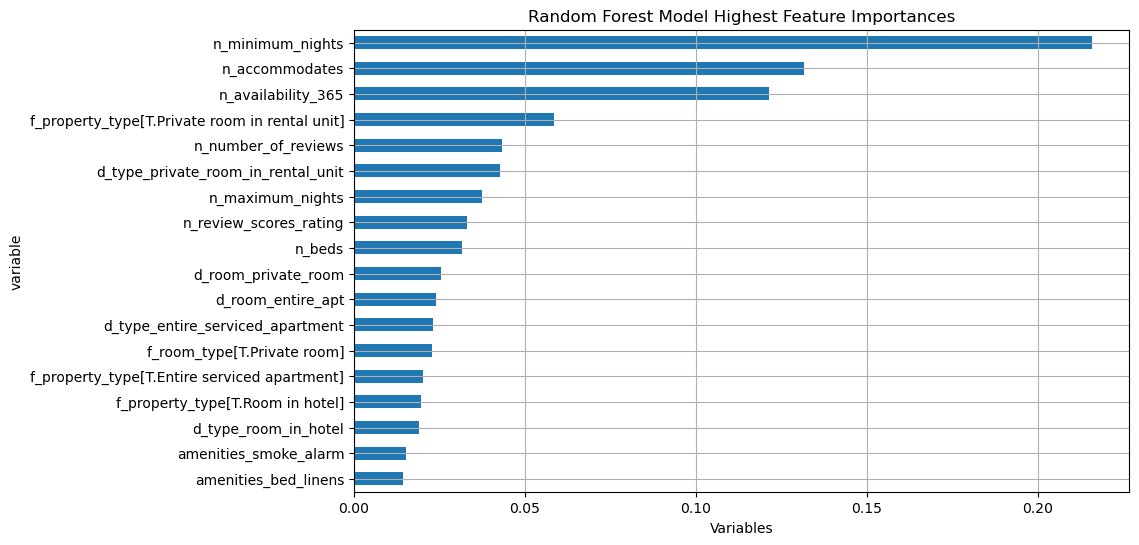

In [43]:
model_diagnostics(rf_model_2, data_train, predictors_2)

***grouped variable importance - keep binaries created off factors together***

For this, you need to create an `sklearn` Pipeline inclduing `OneHotEncoding` (before, encoding was done by patsy's `dmatrices`). This way permutation_importance can calculate factor variables' importance 

In [46]:
# was having a lot of issues with the column 'd_host_is_superhost' getting repeated
# this corrected the issue
predictors_2 = list(dict.fromkeys(predictors_2))

In [47]:
# Identify categorical and numerical columns from the predictors to prepare for preprocessing.
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]


In [48]:
# Initialize OneHotEncoder for categorical variables to handle unseen categories during transformation.
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Setup preprocessing steps: one-hot encode categorical variables and pass through numerical variables.
preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

# Setup preprocessing steps: one-hot encode categorical variables and pass through numerical variables.
rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)


In [49]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

# Fit the pipeline on the training data, ensuring that data is preprocessed before fitting the model.

CPU times: total: 188 ms
Wall time: 749 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'd_host_is_superhost',
                                                   'n_availability_365',
                                                   'n_maximum_nights',
                                                   'n_minimum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'amenities_bed_linens',
                                                   'ameniti...
                                                   'amenities_shampoo',
                                                   'amenities_smoke_alarm',
                                                   'amenities_washer',
                                                   'amenities_wifi',
                                                   'd_room_entire_apt',
                                                   'd_room_private_room',
                                                   'd_type_entire_condo',
                                                   'd_type_entire_home',
                                                   'd_type_entire_loft',
                                                   'd_type_entire_rental_unit',
                                                   'd_type_entire_serviced_apartment', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=6, min_samples_leaf=5,
                                       random_state=20240211))])

In [50]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

# Calculate permutation importance on the holdout set to evaluate the importance of features,
# using 10 repeats for stability of importance estimation.

CPU times: total: 2.45 s
Wall time: 16.9 s


In [51]:

result


{'importances_mean': array([ 9.61066017e-02,  1.11920714e-02,  3.59909267e-02,  2.41100965e-02,
         2.55984246e-03,  5.34215296e-02,  1.05425263e-02,  1.57241362e-01,
         1.05111512e-02,  9.35872948e-03,  8.18641413e-03,  5.80437777e-03,
         3.44816564e-03,  4.03196193e-04,  2.11305032e-03,  2.01733162e-03,
         1.62300744e-03,  1.13214958e-03,  5.06977514e-03,  2.94658458e-03,
         3.42838814e-03,  4.59054390e-03,  8.12343639e-03,  3.57325452e-03,
         8.98680040e-04,  1.22628441e-02,  1.06462597e-02, -1.75824974e-04,
        -1.26859367e-04,  7.62078648e-04,  4.58291898e-03,  1.05882424e-02,
         1.60910748e-04,  7.08635200e-04,  1.01314122e-02,  1.72886607e-02]),
 'importances_std': array([6.87876815e-03, 1.39249901e-03, 2.05982913e-03, 2.39010798e-03,
        5.80616355e-04, 4.25553148e-03, 1.19768595e-03, 6.84600319e-03,
        1.89035091e-03, 1.34557273e-03, 1.18080270e-03, 9.45548362e-04,
        6.65053173e-04, 2.43242276e-04, 6.84855022e-04, 3.1

In [52]:
# Create a DataFrame to display the mean importance of each feature.
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)


,0
n_accommodates,0.096107
n_beds,0.011192
f_property_type,0.035991
f_room_type,0.024110
d_host_is_superhost,0.002560
n_availability_365,0.053422
n_maximum_nights,0.010543
n_minimum_nights,0.157241
n_number_of_reviews,0.010511
n_review_scores_rating,0.009359


In [53]:

grouped = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "d_host_is_superhost",
    "n_availability_365",
    "n_maximum_nights",
    "n_minimum_nights",
]


In [54]:
# Grouped variable importance for selected variables, focusing on the predefined 'grouped' list.
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

# Calculate and format cumulative importance for grouped variables.
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()


In [55]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})


,variable,imp,cumulative_imp
0,n_minimum_nights,15.7%,15.7%
1,n_accommodates,9.6%,25.3%
2,n_availability_365,5.3%,30.7%
3,f_property_type,3.6%,34.3%
4,f_room_type,2.4%,36.7%
5,n_beds,1.1%,37.8%
6,n_maximum_nights,1.1%,38.9%
7,d_host_is_superhost,0.3%,39.1%


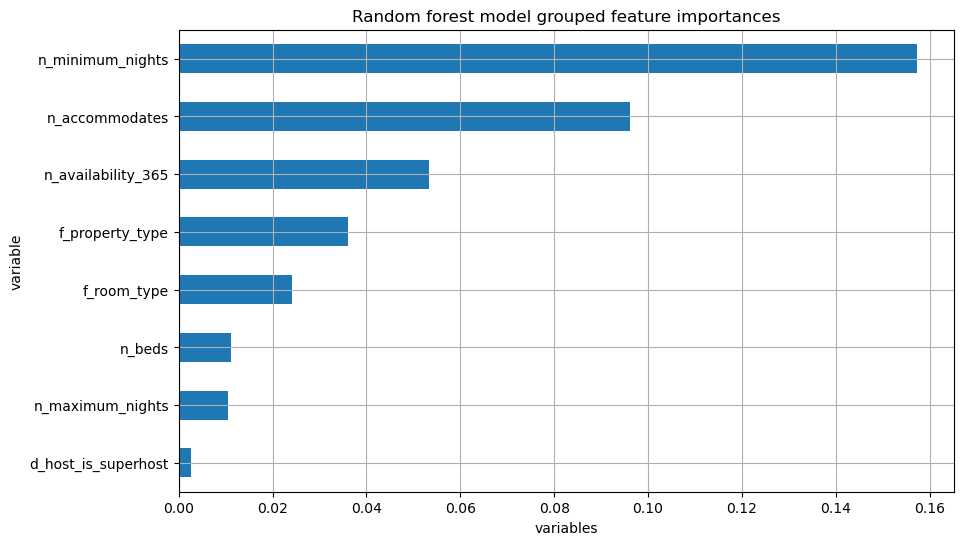

In [56]:
# Visualize the feature importances for grouped variables in a bar chart.
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );


In [58]:
# Create a cleaned DataFrame of variable importances, focusing on variables contributing to 91% of the importance.
df_clean_varimp = pd.DataFrame(
    result.importances_mean,
    index=data_train[predictors_2].columns)\
.sort_values(by=0, ascending=False)\
.reset_index()\
.rename({'index': 'variable', 0: 'imp'}, axis=1)


df_clean_varimp['cumulative_imp'] = df_clean_varimp['imp'].cumsum()

df_filtered_varimp = df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]



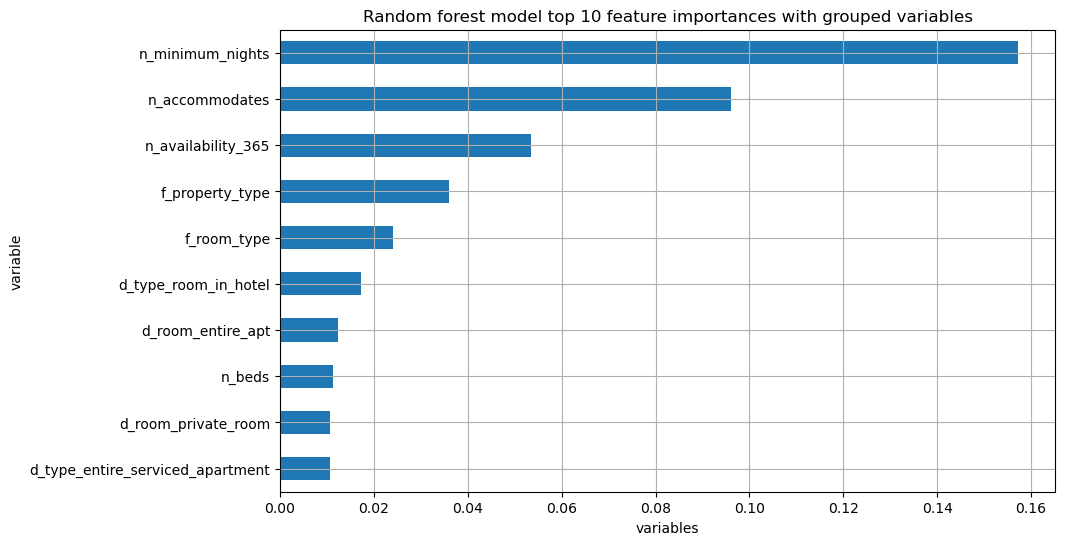

In [59]:
# Visualize the top 10 important features with grouped variables in a bar chart.
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );


### Partial dependence plots 

Note: easy way, sklearn has plot_partial_dependence function we do this on holdout set!   
Also, note that we run it not on the `rf_model` but on the `rf_pipeline` to manage OneHot_Encoding on the fly.

In [62]:
# Generate a partial dependence plot for 'n_accommodates' using the fitted Random Forest pipeline.
# This step calculates the effect of 'n_accommodates' on the predicted 'price' while holding other predictors constant.
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)


In [63]:
# Display the partial dependence object to inspect its contents.
accomodates_pdp


{'grid_values': [array([2, 3, 4, 5, 6])],
 'values': [array([2, 3, 4, 5, 6])],
 'average': array([[ 89.25634311,  92.97915484, 108.62848006, 114.21257581,
         115.62403254]])}

In [64]:
# Check the type of the partial dependence result to understand its structure for further processing.
# We need to access the elements of this complex data structure
type(accomodates_pdp)


sklearn.utils._bunch.Bunch

In [65]:
# Create a DataFrame from the partial dependence results.
# This DataFrame maps the number of accommodations to the average predicted price, showing the relationship.
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )


,number of accomodates,average price
0,2,89.256343
1,3,92.979155
2,4,108.628480
3,5,114.212576
4,6,115.624033


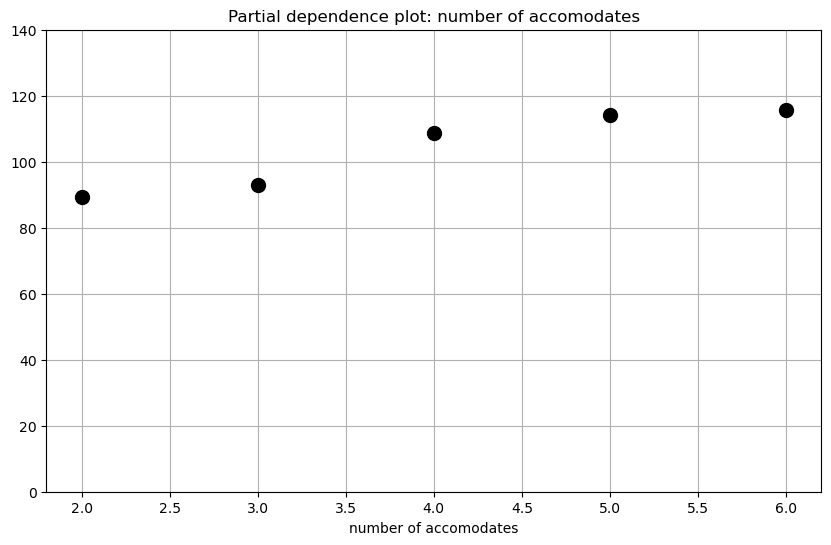

In [66]:
# Plot the relationship between 'number of accomodates' and 'average price' as a line plot.
# This visualization helps interpret how changes in the number of accommodations relate to the pricing.
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: number of accomodates'
);


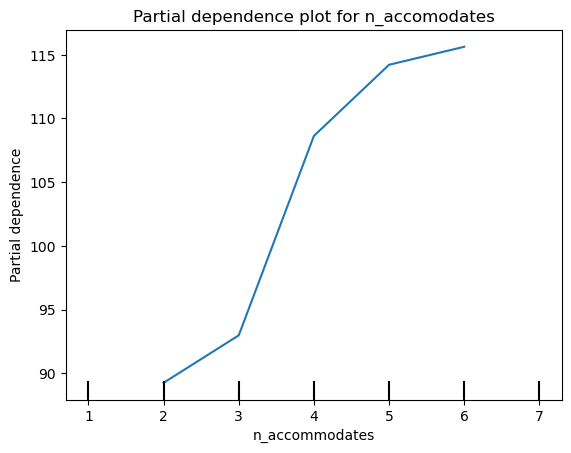

In [67]:
# Utilize PartialDependenceDisplay for a more standardized visualization of the partial dependence plot.
# This approach allows for easier integration and customization of the plot presentation.
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)} # Deciles provide a way to segment the feature values for visualization.
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();


In [68]:
# Repeat the process for 'f_room_type' to understand its impact on the predicted 'price'.
# Generate a partial dependence plot, create a DataFrame from the results, and visualize the relationship.
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)


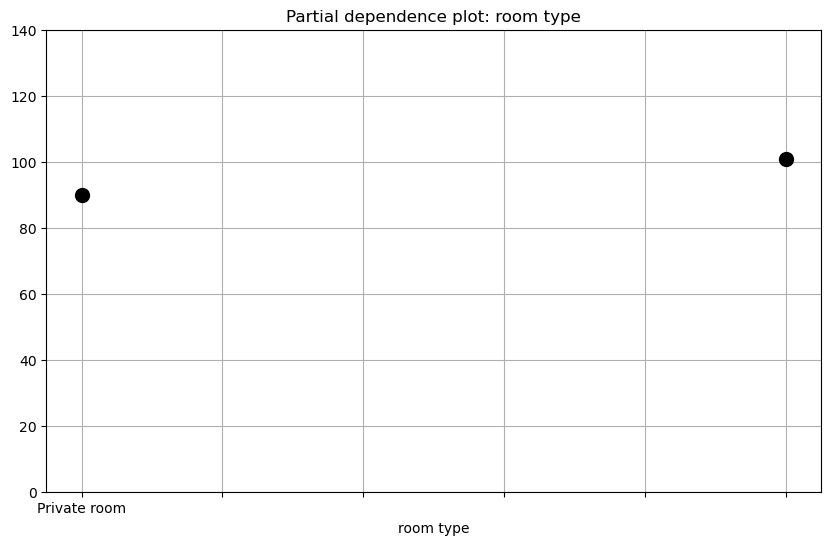

In [69]:
# This DataFrame and plot showcase how different room types relate to the average predicted price,
# highlighting the effect of room type on pricing decisions.
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: room type'
);


## ***OLS with dummies for area***

 using model B

In [85]:
def calculate_ols_model(predictors, data_train, data_holdout):
    # Prepare the design matrices
    y, X = dmatrices("price ~ " + " + ".join(predictors), data_train)
    
    # Initialize and fit the OLS model
    ols_model = LinearRegression().fit(X, y.ravel())
    
    # Predict using the model
    y_hat = ols_model.predict(X)
    
    # Calculate RMSE
    ols_rmse = mean_squared_error(y, y_hat, squared=False)
    
    # Adjusting DataFrame creation for coefficients
    coeffs = np.concatenate([[ols_model.intercept_], ols_model.coef_])
    
    # Adjusting for the intercept if present, plus feature names from the design matrix
    column_names = ['Intercept'] + X.design_info.column_names
    
    # Create coefficients DataFrame
    ols_model_coeffs_df = pd.DataFrame(
        coeffs,
        index=column_names,
        columns=["ols_coefficient"]
    ).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))  # Round coefficients for readability
    
    # Return RMSE and coefficients DataFrame
    return ols_rmse, ols_model_coeffs_df

In [96]:
ols_rmse_1, ols_model_coeffs_df_1 = calculate_ols_model(predictors_1, data_train, data_holdout)

print("OLS RMSE for Predictors 1:", ols_rmse_1)
print("OLS Model Coefficients for Predictors 1:")
print(ols_model_coeffs_df_1)


OLS RMSE for Predictors 1: 40.90656913873867
OLS Model Coefficients for Predictors 1:
                                                ols_coefficient
Intercept                                                79.938
Intercept                                                 0.000
f_property_type[T.Entire home]                          -16.142
f_property_type[T.Entire loft]                           10.298
f_property_type[T.Entire rental unit]                   -13.788
f_property_type[T.Entire serviced apartment]             48.432
f_property_type[T.Private room in condo]                -22.595
f_property_type[T.Private room in home]                 -49.609
f_property_type[T.Private room in rental unit]          -25.455
f_property_type[T.Room in hotel]                         78.705
f_room_type[T.Private room]                             -18.955
n_accommodates                                           14.872
n_beds                                                    0.467
d_host_is_superhos

In [95]:
ols_rmse_2, ols_model_coeffs_df_2 = calculate_ols_model(predictors_2, data_train, data_holdout)


print("OLS RMSE for Predictors 2:", ols_rmse_1)
print("OLS Model Coefficients for Predictors 2:")
print(ols_model_coeffs_df_2)

OLS RMSE for Predictors 2: 40.90656913873867
OLS Model Coefficients for Predictors 2:
                                                ols_coefficient
Intercept                                                68.221
Intercept                                                 0.000
f_property_type[T.Entire home]                           -8.465
f_property_type[T.Entire loft]                            4.552
f_property_type[T.Entire rental unit]                    -7.495
f_property_type[T.Entire serviced apartment]             22.266
f_property_type[T.Private room in condo]                -11.319
f_property_type[T.Private room in home]                 -23.461
f_property_type[T.Private room in rental unit]          -11.091
f_property_type[T.Room in hotel]                         38.919
f_room_type[T.Private room]                              -6.951
n_accommodates                                           14.749
n_beds                                                    0.719
d_host_is_superhos

In [94]:
ols_rmse_E, ols_model_coeffs_df_E = calculate_ols_model(predictors_E, data_train, data_holdout)

print("OLS RMSE for Predictors E:", ols_rmse_E)
print("OLS Model Coefficients for Predictors E:")
print(ols_model_coeffs_df_E)

OLS RMSE for Predictors E: 39.59306109150218
OLS Model Coefficients for Predictors E:
                                            ols_coefficient
Intercept                                            74.533
Intercept                                            -0.000
f_property_type[T.Entire home]                      -14.722
f_property_type[T.Entire loft]                        8.326
f_property_type[T.Entire rental unit]                -8.557
...                                                     ...
amenities_kitchen:n_accommodates                      6.175
n_number_of_reviews:n_review_scores_rating            0.223
amenities_essentials:amenities_hair_dryer             2.580
amenities_kitchen:amenities_washer                    3.143
d_host_is_superhost:n_review_scores_rating           -4.663

[70 rows x 1 columns]


In [102]:
rmse_comparison = pd.DataFrame({
    'OLS Model': ['Pred 1', 'Pred 2', 'Pred E'],
    'RMSE Score': [ols_rmse_1, ols_rmse_2, ols_rmse_E]
})

rmse_comparison

,OLS Model,RMSE Score
0,Pred 1,40.906569
1,Pred 2,39.937257
2,Pred E,39.593061


## ***CART model***

In [109]:
from patsy import dmatrices
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import time

def fit_and_optimize_CART_model(predictors, data_train):
    """
    Fits a CART model to the training data, optimizes ccp_alpha using cross-validation,
    calculates RMSE, and measures execution time.
    
    Parameters:
    - predictors: List of predictor variables as strings.
    - data_train: DataFrame containing the training data including the target variable 'price'.
    
    Returns:
    - The RMSE of the CART model using the best ccp_alpha.
    - The best ccp_alpha value.
    - Execution time for the function.
    """
    start_time = time.time()  # Start timer
    
    # Prepare the design matrices
    y, X = dmatrices("price ~ " + " + ".join(predictors), data_train)
    
    # Initialize the CART model
    cart_model = DecisionTreeRegressor(random_state=20240211)
    
    # Determine the path for cost complexity pruning
    path = cart_model.cost_complexity_pruning_path(X, y.ravel())
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    print("ccp_alphas")
    print(ccp_alphas)
    
    print("ccp alphas shape")
    print(ccp_alphas.shape)
    
    # Perform cross-validation to find the best ccp_alpha
    cart_model_cv = RandomizedSearchCV(
        cart_model,
        {"ccp_alpha":ccp_alphas},
        cv=5,
        scoring="neg_root_mean_squared_error",
        verbose=3,
    )
    cart_model_cv.fit(X,y.ravel())
    
    cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
        lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
    ].mean_test_score.values[0] * -1
    cart_rmse
    
    end_time = time.time()  # End timer
    execution_time = end_time - start_time  # Calculate execution time
    
    # Return the best RMSE, ccp_alpha, and execution time
    return cart_rmse, cart_model_cv.best_estimator_.ccp_alpha, execution_time


In [112]:
cart_rmse_1, best_ccp_alpha_1, execution_time = fit_and_optimize_CART_model(predictors_1, data_train)
print(f"Best CART RMSE Predictors 1: {cart_rmse_1}")
print(f"Best ccp_alpha Predictors 1: {best_ccp_alpha_1}")
print(f"Execution time: {execution_time:.2f} seconds")

ccp_alphas
[ 0.00000000e+00 -6.59194921e-17  1.32096906e-06 ...  1.39105780e+02
  3.22245764e+02  8.11951725e+02]
ccp alphas shape
(3487,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...ccp_alpha=0.03274241983919227;, score=-49.471 total time=   0.0s
[CV 2/5] END ...ccp_alpha=0.03274241983919227;, score=-53.334 total time=   0.0s
[CV 3/5] END ...ccp_alpha=0.03274241983919227;, score=-54.196 total time=   0.0s
[CV 4/5] END ...ccp_alpha=0.03274241983919227;, score=-51.850 total time=   0.0s
[CV 5/5] END ...ccp_alpha=0.03274241983919227;, score=-51.851 total time=   0.0s
[CV 1/5] END ..ccp_alpha=0.016346992153443766;, score=-49.457 total time=   0.0s
[CV 2/5] END ..ccp_alpha=0.016346992153443766;, score=-53.510 total time=   0.0s
[CV 3/5] END ..ccp_alpha=0.016346992153443766;, score=-54.274 total time=   0.0s
[CV 4/5] END ..ccp_alpha=0.016346992153443766;, score=-52.093 total time=   0.0s
[CV 5/5] END ..ccp_alpha=0.016346992153443766;, score=-51.926 total tim

In [113]:
cart_rmse_2, best_ccp_alpha_2, execution_time = fit_and_optimize_CART_model(predictors_2, data_train)
print(f"Best CART RMSE Predictors 2: {cart_rmse_2}")
print(f"Best ccp_alpha Predictors 2: {best_ccp_alpha_2}")
print(f"Execution time Predictors 2: {execution_time:.2f} seconds")

ccp_alphas
[  0.           0.           0.         ... 139.10578045 322.2457639
 811.95172481]
ccp alphas shape
(5162,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..ccp_alpha=0.007265329845975007;, score=-51.211 total time=   0.0s
[CV 2/5] END ..ccp_alpha=0.007265329845975007;, score=-53.447 total time=   0.0s
[CV 3/5] END ..ccp_alpha=0.007265329845975007;, score=-52.159 total time=   0.0s
[CV 4/5] END ..ccp_alpha=0.007265329845975007;, score=-54.284 total time=   0.0s
[CV 5/5] END ..ccp_alpha=0.007265329845975007;, score=-53.483 total time=   0.0s
[CV 1/5] END .ccp_alpha=0.0003874842584527052;, score=-51.225 total time=   0.0s
[CV 2/5] END .ccp_alpha=0.0003874842584527052;, score=-53.424 total time=   0.0s
[CV 3/5] END .ccp_alpha=0.0003874842584527052;, score=-52.164 total time=   0.0s
[CV 4/5] END .ccp_alpha=0.0003874842584527052;, score=-54.334 total time=   0.0s
[CV 5/5] END .ccp_alpha=0.0003874842584527052;, score=-53.415 total time=   0.0s
[CV 1/5] 

In [114]:
cart_rmse_E, best_ccp_alpha_E, execution_time = fit_and_optimize_CART_model(predictors_E, data_train)
print(f"Best CART RMSE Predictors E: {cart_rmse_E}")
print(f"Best ccp_alpha Predictors E: {best_ccp_alpha_E}")
print(f"Execution time Predictors E: {execution_time:.2f} seconds")


ccp_alphas
[  0.           0.           0.         ... 139.10578045 322.2457639
 811.95172481]
ccp alphas shape
(5255,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..ccp_alpha=0.038043688850140485;, score=-51.750 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.038043688850140485;, score=-53.800 total time=   0.1s
[CV 3/5] END ..ccp_alpha=0.038043688850140485;, score=-52.924 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.038043688850140485;, score=-52.601 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.038043688850140485;, score=-53.620 total time=   0.0s
[CV 1/5] END .ccp_alpha=0.0018163324614937518;, score=-52.035 total time=   0.0s
[CV 2/5] END .ccp_alpha=0.0018163324614937518;, score=-53.974 total time=   0.0s
[CV 3/5] END .ccp_alpha=0.0018163324614937518;, score=-53.297 total time=   0.0s
[CV 4/5] END .ccp_alpha=0.0018163324614937518;, score=-52.931 total time=   0.0s
[CV 5/5] END .ccp_alpha=0.0018163324614937518;, score=-53.748 total time=   0.0s
[CV 1/5] 

In [115]:
rmse_comparison = pd.DataFrame({
    'CART Model': ['Pred 1', 'Pred 2', 'Pred E'],
    'RMSE Score': [cart_rmse_1, cart_rmse_2, cart_rmse_E]
})

rmse_comparison

,CART Model,RMSE Score
0,Pred 1,40.711007
1,Pred 2,51.870307
2,Pred E,51.052423


## Model Comparison

In [116]:
# RMSE scores for each model and predictor set
cart_rmse_scores = [cart_rmse_1, cart_rmse_2, cart_rmse_E]
ols_rmse_scores = [ols_rmse_1, ols_rmse_2, ols_rmse_E]
rf_rmse_scores = [rmse_1, rmse_2, rmse_E]

# DataFrame to compare RMSE scores across models
model_comparison = pd.DataFrame({
    'Predictor Set': ['Pred 1', 'Pred 2', 'Pred E'],
    'CART RMSE': cart_rmse_scores,
    'OLS RMSE': ols_rmse_scores,
    'RF RMSE': rf_rmse_scores
})

model_comparison


,Predictor Set,CART RMSE,OLS RMSE,RF RMSE
0,Pred 1,40.711007,40.906569,38.680481
1,Pred 2,51.870307,39.937257,37.449600
2,Pred E,51.052423,39.593061,37.716051
